# Create Cases in Batch and Run in Parallel

This notebook demonstrates creating cases in batch and running them in parallel.

## Create Cases in Batch

The approach to create cases in batch following this procedure:

- Load the base case from file
- For each desired case output:
  * Alter parameters to the desired value
  * Save each system to a new case file

In [1]:
import andes
import numpy as np
from andes.utils.paths import get_case

andes.config_logger()

In [2]:
# create directory for output cases
!rm -rf batch_cases
!mkdir -p batch_cases

In [3]:
kundur = get_case('kundur/kundur_full.xlsx')
ss = andes.load(kundur)

Parsing input file "/Users/hcui7/repos/andes/andes/cases/kundur/kundur_full.xlsx"
Input file parsed in 0.0625 second.


We demonstrate running the Kundur's system under different loading conditions.

Cases are created by modifying the `p0` of `PQ` with `idx == PQ_0`.

As always, input parameters can be inspected in `cache.df_in`. 

In [4]:
p0_base = ss.PQ.get('p0', "PQ_0")

Create 10 cases so that the load increases from `p0_base` to `1.2 * p0_base`.

In [5]:
p0_values = np.linspace(p0_base, 1.2 * p0_base, 10)

In [6]:
for value in p0_values:
    ss.PQ.alter('p0', 'PQ_0', value)
    file_name = f'batch_cases/kundur_p_{value:.2f}.xlsx'
    
    andes.io.dump(ss, 'xlsx', file_name, overwrite=True)

xlsx file written to "batch_cases/kundur_p_11.59.xlsx"
Format conversion completed in 0.0783 second.
xlsx file written to "batch_cases/kundur_p_11.85.xlsx"
Format conversion completed in 0.0518 second.
xlsx file written to "batch_cases/kundur_p_12.11.xlsx"
Format conversion completed in 0.0584 second.
xlsx file written to "batch_cases/kundur_p_12.36.xlsx"
Format conversion completed in 0.0536 second.
xlsx file written to "batch_cases/kundur_p_12.62.xlsx"
Format conversion completed in 0.0567 second.
xlsx file written to "batch_cases/kundur_p_12.88.xlsx"
Format conversion completed in 0.0555 second.
xlsx file written to "batch_cases/kundur_p_13.14.xlsx"
Format conversion completed in 0.0513 second.
xlsx file written to "batch_cases/kundur_p_13.39.xlsx"
Format conversion completed in 0.0531 second.
xlsx file written to "batch_cases/kundur_p_13.65.xlsx"
Format conversion completed in 0.0505 second.
xlsx file written to "batch_cases/kundur_p_13.91.xlsx"
Format conversion completed in 0.048

## Parallel Simulation

Parallel simulation is easy with the command line tool.

Change directory to `batch_cases`:

In [7]:
import os

# change the Python working directory
os.chdir('batch_cases')

In [8]:
!ls -la

total 320
drwxr-xr-x  12 hcui7  staff    384 Apr 23 19:54 .
drwxr-xr-x  12 hcui7  staff    384 Apr 23 19:54 ..
-rw-r--r--   1 hcui7  staff  14599 Apr 23 19:54 kundur_p_11.59.xlsx
-rw-r--r--   1 hcui7  staff  14604 Apr 23 19:54 kundur_p_11.85.xlsx
-rw-r--r--   1 hcui7  staff  14603 Apr 23 19:54 kundur_p_12.11.xlsx
-rw-r--r--   1 hcui7  staff  14604 Apr 23 19:54 kundur_p_12.36.xlsx
-rw-r--r--   1 hcui7  staff  14603 Apr 23 19:54 kundur_p_12.62.xlsx
-rw-r--r--   1 hcui7  staff  14602 Apr 23 19:54 kundur_p_12.88.xlsx
-rw-r--r--   1 hcui7  staff  14602 Apr 23 19:54 kundur_p_13.14.xlsx
-rw-r--r--   1 hcui7  staff  14603 Apr 23 19:54 kundur_p_13.39.xlsx
-rw-r--r--   1 hcui7  staff  14603 Apr 23 19:54 kundur_p_13.65.xlsx
-rw-r--r--   1 hcui7  staff  14600 Apr 23 19:54 kundur_p_13.91.xlsx


### Running from Command line

In [9]:
!andes run *.xlsx -r tds


    _           _         | Version 0.8.5.post39.dev0+ga1b7093a
   /_\  _ _  __| |___ ___ | Python 3.7.1 on Darwin, 04/23/2020 07:54:10 PM
  / _ \| ' \/ _` / -_|_-< | 
 /_/ \_\_||_\__,_\___/__/ | This program comes with ABSOLUTELY NO WARRANTY.

Working directory: "/Users/hcui7/repos/andes/examples/batch_cases"
-> Processing 10 jobs on 16 CPUs.
Process 0 for "kundur_p_11.59.xlsx" started.
Process 1 for "kundur_p_11.85.xlsx" started.
Process 2 for "kundur_p_12.11.xlsx" started.
Process 3 for "kundur_p_12.36.xlsx" started.
Process 4 for "kundur_p_12.62.xlsx" started.
Process 5 for "kundur_p_12.88.xlsx" started.
Process 6 for "kundur_p_13.14.xlsx" started.
Process 7 for "kundur_p_13.39.xlsx" started.
Process 8 for "kundur_p_13.65.xlsx" started.
Process 9 for "kundur_p_13.91.xlsx" started.
<Toggle 1>: Status of Line.Line_8 changed to 0.0 at t=2.0sec.
<Toggle 1>: Status of Line.Line_8 changed to 0.0 at t=2.0sec.
<Toggle 1>: Status of Line.Line_8 changed to 0.0 at t=2.0sec.
<Toggle 1>: Statu

### Number of CPUs

In some cases, you don't want the simulatino to use up all resources. 

ANDES allows to control the number of processes to run in parallel through `--ncpu NCPU`, where `NCPU` is the maximum number of processes (equivalent to the number of CPU cores) allowed. 

In [10]:
!andes run *.xlsx -r tds --ncpu 4


    _           _         | Version 0.8.5.post39.dev0+ga1b7093a
   /_\  _ _  __| |___ ___ | Python 3.7.1 on Darwin, 04/23/2020 07:54:15 PM
  / _ \| ' \/ _` / -_|_-< | 
 /_/ \_\_||_\__,_\___/__/ | This program comes with ABSOLUTELY NO WARRANTY.

Working directory: "/Users/hcui7/repos/andes/examples/batch_cases"
-> Processing 10 jobs on 4 CPUs.
Process 0 for "kundur_p_11.59.xlsx" started.
Process 1 for "kundur_p_11.85.xlsx" started.
Process 2 for "kundur_p_12.11.xlsx" started.
Process 3 for "kundur_p_12.36.xlsx" started.
<Toggle 1>: Status of Line.Line_8 changed to 0.0 at t=2.0sec.
<Toggle 1>: Status of Line.Line_8 changed to 0.0 at t=2.0sec.
<Toggle 1>: Status of Line.Line_8 changed to 0.0 at t=2.0sec.
<Toggle 1>: Status of Line.Line_8 changed to 0.0 at t=2.0sec.
Process 4 for "kundur_p_12.62.xlsx" started.
Process 5 for "kundur_p_12.88.xlsx" started.
Process 6 for "kundur_p_13.14.xlsx" started.
Process 7 for "kundur_p_13.39.xlsx" started.
<Toggle 1>: Status of Line.Line_8 changed to 0

### Running with APIs

Setting `pool = True` allows returning all system instances in a list. 

This comes with a penalty in computation time but can be helpful if you want to extract data directly.

In [12]:
systems = andes.run('*.xlsx', routine='tds', pool=True, verbose=10)

Cases are processed in the following order:
"kundur_p_11.59.xlsx"
"kundur_p_11.85.xlsx"
"kundur_p_12.11.xlsx"
"kundur_p_12.36.xlsx"
"kundur_p_12.62.xlsx"
"kundur_p_12.88.xlsx"
"kundur_p_13.14.xlsx"
"kundur_p_13.39.xlsx"
"kundur_p_13.65.xlsx"
"kundur_p_13.91.xlsx"
<Toggle 1>: Status of Line.Line_8 changed to 0.0 at t=2.0sec.
<Toggle 1>: Status of Line.Line_8 changed to 0.0 at t=2.0sec.
<Toggle 1>: Status of Line.Line_8 changed to 0.0 at t=2.0sec.
<Toggle 1>: Status of Line.Line_8 changed to 0.0 at t=2.0sec.
<Toggle 1>: Status of Line.Line_8 changed to 0.0 at t=2.0sec.
<Toggle 1>: Status of Line.Line_8 changed to 0.0 at t=2.0sec.
<Toggle 1>: Status of Line.Line_8 changed to 0.0 at t=2.0sec.
<Toggle 1>: Status of Line.Line_8 changed to 0.0 at t=2.0sec.
<Toggle 1>: Status of Line.Line_8 changed to 0.0 at t=2.0sec.
<Toggle 1>: Status of Line.Line_8 changed to 0.0 at t=2.0sec.
Log saved to "/var/folders/4h/t6nlrnps6_l_wzjjt6wj04th0000gp/T/andes-cbvhc81g/andes.log".
-> Multiprocessing finishe

In [13]:
systems

### Example plots

Plotting or data analyses can be carried out as usual.

In [14]:
ss = systems[0]

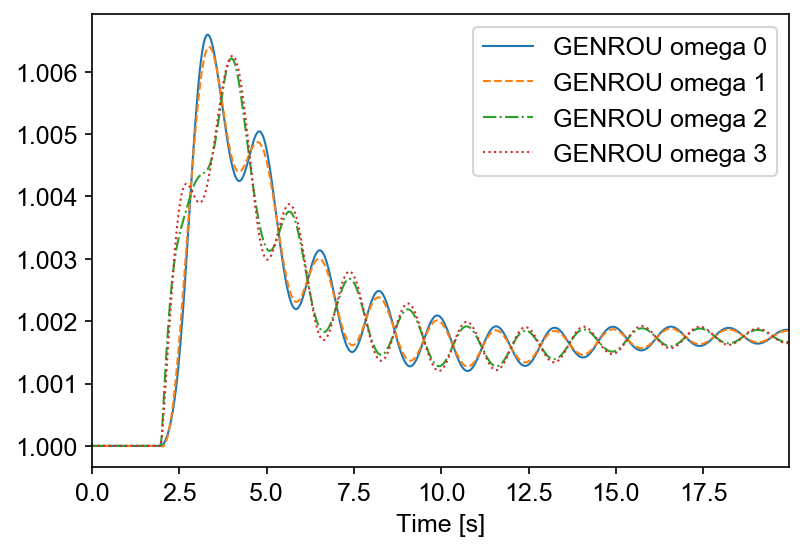

(<Figure size 900x600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12da42438>)

In [15]:
systems[0].TDS.plotter.plot(ss.GENROU.omega, latex=False)

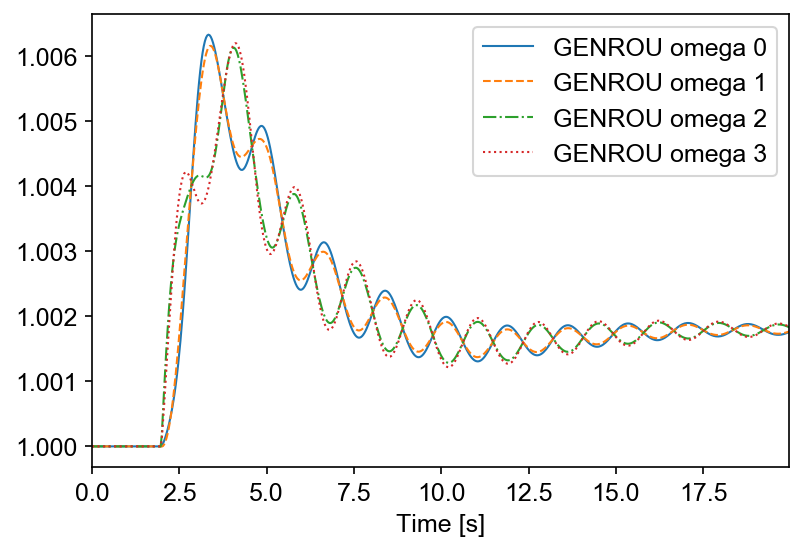

(<Figure size 900x600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12de2a358>)

In [16]:
systems[5].TDS.plotter.plot(ss.GENROU.omega, latex=False)